### Spring-Beam

##### Purpose:
Simulate the coupled equations of motion for an Euler–Bernoulli beam (x_b ∈ ℝ^{n_b}) with an attached compliant spring–mass patch (y ∈ ℝ^{n_m}) via interface springs.

Inputs and model definitions:
- n_b, n_m: number of beam and patch DOFs
- Beam matrices: M_b (mass), K_b (structural stiffness)
- Patch/interface matrices: M_m (patch mass), K_c (interface spring stiffness)
- Coupling: S (beam-to-attachment displacement mapping), giving attachment displacement S x_b
- Forcing: f_b(t), external time-dependent force applied to the beam
- Initial conditions: u0 = [x_b0; y0; ẋ_b0; ẏ0]
- Time span and solver tolerances

##### Method:
Compute the interface spring extension δ = y − S x_b and the associated spring forces K_c δ. Map patch forces back to generalized beam forces with Sᵀ. Form the second-order accelerations from the governing EOMs, then rewrite as a first-order ODE in u = [x_b; y; ẋ_b; ẏ]. Integrate the ODE with OrdinaryDiffEq (Tsit5).

##### Outputs:
- sol.t: saved time points
- sol.u: saved state vectors u(t) = [x_b(t); y(t); ẋ_b(t); ẏ(t)]
These outputs provide beam and patch displacement/velocity time histories, which can be printed or plotted (e.g., x_b[1](t), y[1](t)).

In [13]:
using LinearAlgebra
using OrdinaryDiffEq
using Printf

# -------------------------------------------------------------------
# GOVERNING EQUATIONS
#
# Beam generalized coordinates:        x_b  ∈ ℝ^{n_b}
# Patch internal coordinates:          y    ∈ ℝ^{n_m}
#
# Relative interface displacement:
#     δ = y - S x_b
#
# Beam equation:
#     M_b ẍ_b + K_b x_b = f_b + Sᵀ K_c (y - S x_b)
#
# Patch equation:
#     M_p ÿ = K_c (S x_b - y)
#
# S maps beam coordinates to attachment displacement, and K_c enforces interface spring forces.
# -------------------------------------------------------------------


# -------------------------------------------------------------------
# Beam structural model (Euler–Bernoulli generalized coordinates)
# -------------------------------------------------------------------
# n_b = number of beam generalized DOFs (modal or nodal coordinates)
# "Beam with n_b DOFs" means approximating the beam using n_b discrete generalized coordinates.
# Each coordinate represents an independent displacement variable.
# How "detailed" the model should be / how many chunks the beam is split up into
# x_b = [x1 x2 ... x_nb]^T
n_b = 4

# Beam mass matrix M_b
# Represents inertia of beam coordinates in generalized form
# Each DOF / chunk has a mass of whatever you put in the diagonal
Mb = Diagonal(fill(2.0, n_b))

# Beam structural stiffness matrix K_b
# Constructed as a nearest-neighbor structural coupling:
# Each chunk interacts only with adjacent chunks, approximating bending coupling in a discretized beam operator.
Kb = zeros(n_b, n_b)
for i in 1:n_b
    if i > 1
        Kb[i,i-1] = -30.0   # coupling to previous coordinate
    end
    if i < n_b
        Kb[i,i+1] = -30.0   # coupling to next coordinate
    end
    # diagonal stiffness contribution
    Kb[i,i] = 60.0*(i < n_b ? 1.0 : 0.5)
end

# boundary stiffness modifications (boundary conditions)
Kb[1,1] = 50.0
Kb[end,end] = 30.0


# -------------------------------------------------------------------
# Internal patch subsystem
# -------------------------------------------------------------------
# y = internal patch displacement vector
# Each DOF represents one mass in the compliant subsystem.
# Each patch has n_m masses
n_m = 3

m_vals = [0.2, 0.2, 0.2]
k_vals = [200.0, 200.0, 200.0]

# Patch mass matrix M_p
Mm = Diagonal(m_vals)

# Interface stiffness matrix K_c
# Defines restoring forces based on relative beam-patch displacement
Kc = Diagonal(k_vals)


# -------------------------------------------------------------------
# Beam-to-attachment mapping matrix S
# -------------------------------------------------------------------
# w_c = S x_b
#
# Each row evaluates beam displacement at an attachment location.
# Here each patch DOF attaches directly to a corresponding beam DOF.
S = zeros(n_m, n_b)
for j in 1:n_m
    S[j, j] = 1.0
end


# -------------------------------------------------------------------
# External beam forcing f_b(t)
# -------------------------------------------------------------------
# Appears on RHS of beam equation:
#     M_b ẍ_b + K_b x_b = f_b(t) + coupling forces
# How we are shaking the beam
function f_b_time(t)
    f = zeros(n_b)
    f[1] = 1.0 * sin(2π * 1.0 * t)   # harmonic forcing on first beam coordinate
    return f
end


# -------------------------------------------------------------------
# Precompute inverses (this assumes a small system)
# Used to compute accelerations from second-order equations
# -------------------------------------------------------------------
Mb_inv = inv(Matrix(Mb))
Mm_inv = inv(Matrix(Mm))


# -------------------------------------------------------------------
# ODE FORMULATION
#
# Convert second-order system:
#     M z̈ + K z = F
#
# into first-order form using state:
#
# u = [ x_b ; y ; ẋ_b ; ẏ ]
# du = [ ẋ_b ; ẏ ; ẍ_b ; ÿ ]
# -------------------------------------------------------------------

# State vector ordering:
#  u = [ x_b (n_b), y (n_m), x_b_dot (n_b), y_dot (n_m) ]
function coupled_system!(du, u, p, t)

    # unpack generalized coordinates and velocities
    xb  = @view u[1:n_b]
    y   = @view u[n_b+1 : n_b+n_m]
    xbd = @view u[n_b+n_m+1 : n_b+n_m+n_b]
    yd  = @view u[n_b+n_m+n_b+1 : end]

    # ----------------------------------------------------------------
    # Relative interface displacement δ = y − S x_b
    # Determines extension of interface springs
    # ----------------------------------------------------------------
    res_patch = y .- (S * xb)

    # Patch spring force:  f_p = K_c δ
    f_patch_on_masses = Kc * res_patch

    # Equal and opposite generalized force applied to beam:
    # Q_beam = Sᵀ f_p
    f_patch_on_beam = S' * f_patch_on_masses

    # external forcing on beam
    f_ext = f_b_time(t)

    # ----------------------------------------------------------------
    # Beam dynamics
    # M_b ẍ_b = f_b + SᵀK_c(y − Sx_b) − K_b x_b
    # ----------------------------------------------------------------
    xbdd = Mb_inv * (f_ext + f_patch_on_beam - Kb * xb)

    # ----------------------------------------------------------------
    # Patch dynamics
    # M_p ÿ = K_c(Sx_b − y)
    # ----------------------------------------------------------------
    ydd = Mm_inv * (Kc * (S * xb .- y))

    # assemble first-order system
    du[1:n_b] .= xbd
    du[n_b+1 : n_b+n_m] .= yd
    du[n_b+n_m+1 : n_b+n_m+n_b] .= xbdd
    du[n_b+n_m+n_b+1 : end] .= ydd

    return nothing
end


# -------------------------------------------------------------------
# Initial conditions (equilibrium start)
# -------------------------------------------------------------------
x_b0 = zeros(n_b)
y0 = zeros(n_m)
x_b_dot0 = zeros(n_b)
y_dot0 = zeros(n_m)

u0 = vcat(x_b0, y0, x_b_dot0, y_dot0)


# -------------------------------------------------------------------
# Time integration
# -------------------------------------------------------------------
tspan = (0.0, 4.0)
prob = ODEProblem(coupled_system!, u0, tspan)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-9)


# -------------------------------------------------------------------
# Output sample generalized responses
# -------------------------------------------------------------------
println("t, xb[1], y[1]")
for (ti, ui) in zip(sol.t[1:10:end], sol.u[1:10:end])
    xb_sol = ui[1:n_b]
    y_sol  = ui[n_b+1:n_b+n_m]
    @printf("%.3f, %.6e, %.6e\n", ti, xb_sol[1], y_sol[1])
end

t, xb[1], y[1]
0.000, 0.000000e+00, 0.000000e+00
0.044, 4.309219e-05, 3.966803e-06
0.116, 7.372969e-04, 3.762566e-04
0.191, 2.970447e-03, 2.594657e-03
0.275, 7.761922e-03, 7.488777e-03
0.361, 1.464873e-02, 1.455218e-02
0.448, 2.175070e-02, 2.211846e-02
0.535, 2.659906e-02, 2.713693e-02
0.616, 2.718843e-02, 2.806390e-02
0.697, 2.292222e-02, 2.358742e-02
0.787, 1.287894e-02, 1.341678e-02
0.877, -4.910557e-04, -5.695040e-04
0.970, -1.422373e-02, -1.470771e-02
1.059, -2.314652e-02, -2.412568e-02
1.139, -2.531912e-02, -2.635363e-02
1.223, -2.082824e-02, -2.169888e-02
1.312, -9.726436e-03, -1.022236e-02
1.404, 5.239927e-03, 5.437945e-03
1.497, 1.912189e-02, 1.980409e-02
1.585, 2.688471e-02, 2.801035e-02
1.668, 2.714944e-02, 2.813801e-02
1.753, 2.021788e-02, 2.107799e-02
1.842, 7.555530e-03, 7.669496e-03
1.935, -7.308121e-03, -7.696065e-03
2.025, -1.792554e-02, -1.901114e-02
2.109, -2.111395e-02, -2.225211e-02
2.191, -1.649154e-02, -1.762134e-02
2.277, -4.358132e-03, -4.974237e-03
2.372, 1.38

### Coupled system vs beam 

Rewritten coupled system with no spring forcing

In [14]:
using LinearAlgebra
using OrdinaryDiffEq
using Printf
using Plots

# Beam DOFs
n_b = 4
Mb = Diagonal(fill(2.0, n_b))

Kb = zeros(n_b, n_b)
for i in 1:n_b
    if i > 1
        Kb[i,i-1] = -30.0
    end
    if i < n_b
        Kb[i,i+1] = -30.0
    end
    Kb[i,i] = 60.0*(i < n_b ? 1.0 : 0.5)
end
Kb[1,1] = 50.0
Kb[end,end] = 30.0

# Internal masses (no spring forcing!)
n_m = 3
m_vals = fill(0.2, n_m)
Mm = Diagonal(m_vals)

Kc = Diagonal(zeros(n_m))   # NO SPRINGS
S  = zeros(n_m, n_b)        # NO COUPLING

function f_b_time(t)
    f = zeros(n_b)
    f[1] = sin(2π*t)
    return f
end

Mb_inv = inv(Matrix(Mb))
Mm_inv = inv(Matrix(Mm))

function coupled_system!(du, u, p, t)
    xb  = @view u[1:n_b]
    y   = @view u[n_b+1 : n_b+n_m]
    xbd = @view u[n_b+n_m+1 : n_b+n_m+n_b]
    yd  = @view u[n_b+n_m+n_b+1 : end]

    # No spring force
    f_patch_on_beam = zeros(n_b)

    # Beam equation
    xbdd = Mb_inv * (f_b_time(t) + f_patch_on_beam - Kb*xb)

    # Free internal masses: y'' = 0
    ydd = zeros(n_m)

    du[1:n_b] .= xbd
    du[n_b+1 : n_b+n_m] .= yd
    du[n_b+n_m+1 : n_b+n_m+n_b] .= xbdd
    du[n_b+n_m+n_b+1 : end] .= ydd
end

# Initial conditions
u0 = zeros(2n_b + 2n_m)
tspan = (0.0, 4.0)

sol_coupled = solve(ODEProblem(coupled_system!, u0, tspan),
                    Tsit5(), reltol=1e-8, abstol=1e-9)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 240-element Vector{Float64}:
 0.0
 9.999999999999999e-5
 0.0010999999999999998
 0.0065869191830041154
 0.015730348882102396
 0.026369421012804813
 0.03934653935992941
 0.053712598132693384
 0.06944704266851864
 0.08608475906445068
 0.1034704251823809
 0.12137486245356731
 0.13968160894513298
 ⋮
 3.8195178118036233
 3.8357099816514424
 3.852135495960007
 3.868789378322459
 3.8856661980482006
 3.9027578909062917
 3.9200528685993508
 3.9375330091543073
 3.9551678316090135
 3.972927200720532
 3.9908919829514495
 4.0
u: 240-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [5.235987587178843e-13, 3.926990788510575e-21, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5707962423928458e-8, 1.963495345773785e-16, 1.0123705279640127e-24, 0.0, 0.0, 0.0, 0.0]
 [6.969072517178314e-10, 6.324446637002578e-16, 1.3611953688680416e-22, 2.938427984321988e-30, 0.0, 0.0, 0.0, 1.9006511981438112e

Plain EB beam

In [15]:
function eb_system!(du, u, p, t)
    x     = u[1:n_b]
    x_dot = u[n_b+1:end]
    x_ddot = Mb_inv * (f_b_time(t) - Kb*x)
    du[1:n_b] .= x_dot
    du[n_b+1:end] .= x_ddot
end

u0_eb = zeros(2n_b)
sol_beam = solve(ODEProblem(eb_system!, u0_eb, tspan),
                 Tsit5(), reltol=1e-8, abstol=1e-9)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 254-element Vector{Float64}:
 0.0
 9.999999999999999e-5
 0.0010999999999999998
 0.006376118107280806
 0.015065676109204715
 0.025141571752350197
 0.03745723763887162
 0.05109556546595216
 0.06605181167376926
 0.08187199754358176
 0.09840819140115378
 0.11543564159706156
 0.13284000162200413
 ⋮
 3.8359155160147163
 3.8514725550879874
 3.867238181951972
 3.8832073453269156
 3.899372563039225
 3.9157238004770605
 3.93224599034639
 3.948914870495307
 3.965697623654614
 3.982621960662164
 3.999736603283976
 4.0
u: 254-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [5.235987587178843e-13, 3.926990788510575e-21, 0.0, 0.0, 1.5707962423928458e-8, 1.963495345773785e-16, 1.0123705279640127e-24, 0.0]
 [6.969072517178314e-10, 6.324446637002578e-16, 1.3611953688680416e-22, 2.938427984321988e-30, 1.9006511981438112e-6, 2.8747425845796875e-12, 1.7698475374958457e-18, 9.264962722998486e-26]
 [1.35

Plot

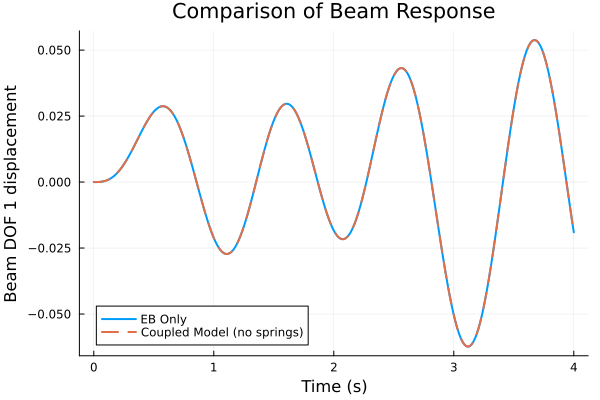

In [16]:
# Extract DOF 1 from both simulations
xb1_coupled = [u[1] for u in sol_coupled.u]
xb1_eb      = [u[1] for u in sol_beam.u]

plot(sol_beam.t, xb1_eb,
     label="EB Only",
     lw=2)

plot!(sol_coupled.t, xb1_coupled,
      label="Coupled Model (no springs)",
      lw=2,
      linestyle=:dash)

xlabel!("Time (s)")
ylabel!("Beam DOF 1 displacement")
title!("Comparison of Beam Response")

with forcing

In [5]:
using LinearAlgebra
using OrdinaryDiffEq
using Plots

# ============================================================
# BEAM PARAMETERS
# ============================================================

n_b = 4
Mb = Diagonal(fill(2.0, n_b))

Kb = zeros(n_b, n_b)
for i in 1:n_b
    if i > 1
        Kb[i,i-1] = -30.0
    end
    if i < n_b
        Kb[i,i+1] = -30.0
    end
    Kb[i,i] = 60.0*(i < n_b ? 1.0 : 0.5)
end
Kb[1,1] = 50.0
Kb[end,end] = 30.0

# External forcing
function f_b_time(t)
    f = zeros(n_b)
    f[1] = sin(2π*t)
    return f
end

# ============================================================
# INTERNAL MASSES WITH SPRING COUPLING
# ============================================================

n_m = 3
m_vals = fill(0.2, n_m)
Mm = Diagonal(m_vals)

k_vals = fill(200.0, n_m)
Kc = Diagonal(k_vals)

# Couple mass j to beam DOF j
S = zeros(n_m, n_b)
for j in 1:n_m
    S[j, j] = 1.0
end

Mb_inv = inv(Matrix(Mb))
Mm_inv = inv(Matrix(Mm))

function coupled_system_with_springs!(du, u, p, t)
    xb  = @view u[1:n_b]
    y   = @view u[n_b+1 : n_b+n_m]
    xbd = @view u[n_b+n_m+1 : n_b+n_m+n_b]
    yd  = @view u[n_b+n_m+n_b+1 : end]

    # Spring residuals
    res = y .- S * xb

    # Forces
    f_mass = Kc * res
    f_beam = -(S' * f_mass)

    # Equations
    xbdd = Mb_inv * (f_b_time(t) + f_beam - Kb * xb)
    ydd  = Mm_inv * (-f_mass)

    du[1:n_b]               .= xbd
    du[n_b+1:n_b+n_m]       .= yd
    du[n_b+n_m+1:n_b+n_m+n_b] .= xbdd
    du[n_b+n_m+n_b+1:end]   .= ydd
end

function eb_system!(du, u, p, t)
    x     = u[1:n_b]
    xdot  = u[n_b+1:end]
    xdd   = Mb_inv * (f_b_time(t) - Kb*x)
    du[1:n_b] .= xdot
    du[n_b+1:end] .= xdd
end

u0_eb = zeros(2n_b)
sol_eb = solve(ODEProblem(eb_system!, u0_eb, (0,4)),
               Tsit5(), reltol=1e-8, abstol=1e-9)

u0_spring = zeros(2n_b + 2n_m)
sol_spring = solve(ODEProblem(coupled_system_with_springs!, u0_spring, (0.0, 4.0)),
                   Tsit5(), reltol=1e-8, abstol=1e-9)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 446-element Vector{Float64}:
 0.0
 9.999999999999999e-5
 0.0010999999999999998
 0.004525814027623883
 0.00949730948217532
 0.014534863260108891
 0.02009495937021022
 0.025919514705380235
 0.03200700516441827
 0.03825057901740475
 0.044620603489887965
 0.051075487667191236
 0.057602943309469606
 ⋮
 3.890652821128656
 3.901375288624658
 3.912274353350436
 3.922867448310305
 3.9332019938428737
 3.943308247855604
 3.953259662265992
 3.9631219141456846
 3.9729765642969888
 3.982910727046671
 3.993010662478977
 4.0
u: 446-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [5.235987848978243e-13, 3.926990788510575e-21, 0.0, 0.0, 2.6179938590070517e-19, 0.0, 0.0, 1.570796373292494e-8, 1.9634954807565235e-16, 1.0123705279640127e-24, 0.0, 1.3089965057326004e-14, 6.74913685309342e-23, 0.0]
 [6.969114679614374e-10, 6.324464786252014e-16, 1.361195956553412e-22, 2.9384

plot with all 3

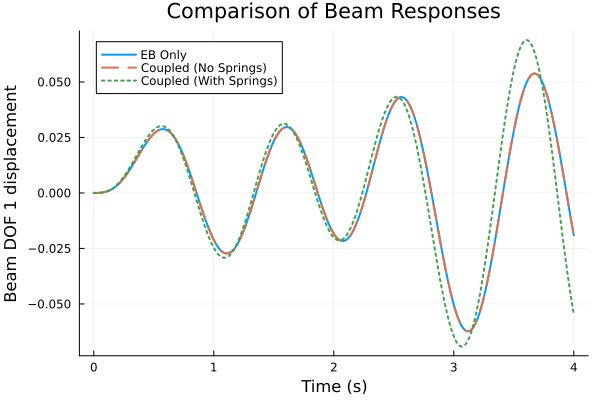

In [17]:
using Plots

# Extract beam DOF 1 from each simulation
xb1_beam     = [u[1] for u in sol_beam.u]
xb1_coupled  = [u[1] for u in sol_coupled.u]
xb1_spring   = [u[1] for u in sol_spring.u]

plot(sol_beam.t, xb1_beam,
     label="EB Only",
     lw=2)

plot!(sol_coupled.t, xb1_coupled,
      label="Coupled (No Springs)",
      lw=2,
      linestyle=:dash)

plot!(sol_spring.t, xb1_spring,
      label="Coupled (With Springs)",
      lw=2,
      linestyle=:dot)

xlabel!("Time (s)")
ylabel!("Beam DOF 1 displacement")
title!("Comparison of Beam Responses")